In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import psycopg2 as psy
import pandas.io.sql as psql

# use seaborn plotting defaults
import seaborn as sns; sns.set()


In [9]:
# Load Dataset for cohort_1

connection = psy.connect("dbname=nytd_clean_data user=cguy")

cohort_1 = psql.read_sql("SELECT * FROM cohort_1", connection)

In [10]:
cohort_1 = cohort_1.drop('index',axis=1)
cohort_1.head()

,Wave,StFCID,RepDate_outcomes,OutcmRpt,OutcmDte,OutcmFCS,CurrFTE,CurrPTE,EmplySklls,SocSecrty,...,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,Race,RaceEthn,AgeMP
0,Wave 1: Age 17 Baseline Survey,AK450290395006,2011-03-01,Youth participated,2010-10-08,"Yes, is in FC on Date",No,No,No,"Yes, is receiving SSI or SSDI payments",...,0,0,0,0,0,0,1,1,1,17
1,Wave 1: Age 17 Baseline Survey,AK450290395006,2011-03-01,Youth participated,2010-10-08,"Yes, is in FC on Date",No,No,No,"Yes, is receiving SSI or SSDI payments",...,0,0,0,0,0,0,1,1,1,17
2,Wave 2: Age 19 Followup,AK450290395006,2013-03-01,Youth participated,2012-12-28,"No, is not in FC on Date",No,No,No,No,...,0,0,0,0,0,0,1,1,1,17
3,Wave 2: Age 19 Followup,AK450290395006,2013-03-01,Youth participated,2012-12-28,"No, is not in FC on Date",No,No,No,No,...,0,0,0,0,0,0,1,1,1,17
4,Wave 1: Age 17 Baseline Survey,AK450448396586,2011-03-01,Youth participated,2010-12-28,"Yes, is in FC on Date",No,No,Yes,No,...,0,0,0,0,0,0,0,3,3,17


In [11]:
# Seperate dataframe into feature vars and target vars

targets = cohort_1[['PubFoodAs','PubHousAs','OthrFinAs','HighEdCert','CurrFTE','CurrPTE','EmplySklls','SocSecrty',\
                     'EducAid','PubFinAs','CurrenRoll','CnctAdult','PrescripIn','Homeless','SubAbuse','Incarc',\
                     'Children','Marriage','Medicaid','OthrHlthIn','MedicalIn','MentlHlthIn', 'Wave']]

# targets should only include outcomes data for Wave 2 population

targets = targets[targets.Wave == "Wave 2: Age 19 Followup"]

features = cohort_1[['ILNAsv','AcSuppSv','PSEdSuppSv','CareerSv','EmplyTrSv','BudgetSv','HousEdSv','HlthEdSv',\
                     'FamSuppSv','MentorSv','SILsv','RmBrdFASv','EducFinaSv','OthrFinaSv', 'Wave']]

# features should only include foster youth from both 
# the baseline population (Wave 1) and the first FU survey pop. (Wave 2)...

features = features[features.Wave == "Wave 2: Age 19 Followup"]



In [12]:
targets = targets.drop('Wave', axis=1)
targets.head()

,PubFoodAs,PubHousAs,OthrFinAs,HighEdCert,CurrFTE,CurrPTE,EmplySklls,SocSecrty,EducAid,PubFinAs,...,PrescripIn,Homeless,SubAbuse,Incarc,Children,Marriage,Medicaid,OthrHlthIn,MedicalIn,MentlHlthIn
2,Yes,No,No,None of the above,No,No,No,No,No,No,...,Not Applicable,Yes,No,No,No,Not Applicable,Yes,No,Not Applicable,Not Applicable
3,Yes,No,No,None of the above,No,No,No,No,No,No,...,Not Applicable,Yes,No,No,No,Not Applicable,Yes,No,Not Applicable,Not Applicable
6,No,No,No,High school diploma/GED,No,No,No,No,No,No,...,Not Applicable,No,No,No,No,Not Applicable,No,No,Not Applicable,Not Applicable
7,No,No,No,High school diploma/GED,No,No,No,No,No,No,...,Not Applicable,No,No,No,No,Not Applicable,No,No,Not Applicable,Not Applicable
12,Yes,No,No,High school diploma/GED,No,No,No,No,Yes,No,...,Not Applicable,No,Yes,Yes,No,Not Applicable,Yes,No,Not Applicable,Not Applicable


In [15]:
features = features.drop('Wave', axis=1)
features.head()

,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv
2,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,1
12,1,0,0,0,0,0,0,0,0,0,0,0,1,1


In [16]:
for column in targets:
    print (column + str(targets[column].unique()))

PubFoodAs['Yes' 'No' 'Not Applicable (in Foster Care)' 'Blank' 'Declined']
PubHousAs['No' 'Not Applicable (in Foster Care)' 'Declined' 'Yes' 'Blank']
OthrFinAs['No' 'Yes' 'Declined' 'Blank']
HighEdCert['None of the above' 'High school diploma/GED' 'Blank'
 'Vocational certificate' 'Declined' "Bachelor's Degree"
 'Vocational license' "Associate's Degree" 'Higher degree' None]
CurrFTE['No' 'Yes, employed full time' 'Blank' 'Declined']
CurrPTE['No' 'Yes, employed part time' 'Blank' 'Declined']
EmplySklls['No' 'Yes' 'Blank' 'Declined']
SocSecrty['No' 'Yes, is receiving SSI or SSDI payments' 'Blank' 'Declined']
EducAid['No' 'Yes' 'Declined' 'Blank']
PubFinAs['No' 'Not Applicable (in Foster Care)' 'Declined' 'Yes' 'Blank']
CurrenRoll['No' 'Yes' 'Declined' 'Blank']
CnctAdult['Yes' 'No' 'Blank' 'Declined']
PrescripIn['Not Applicable' 'Yes' 'Blank' "Don't Know" 'Declined' 'No']
Homeless['Yes' 'No' 'Blank' 'Declined']
SubAbuse['No' 'Yes' 'Declined' 'Blank']
Incarc['No' 'Yes' 'Declined' 'Blank']


In [7]:
# Need to categorize into outcome_type in order to have less target vars: several y-vars ==> 4 outcome_types

# Categories of outcome_types: financial: pos/neg, educational: pos/neg, well-being: pos/neg, health: pos/neg

# Protocol Used to define pos/neg for each outcome_type:
    # - Positive Educational: 

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(features)
print(pca.explained_variance_)
print(pca.components_)

[  3.59414733e+03   2.99518906e-01   2.29349174e-01   1.82087458e-01
   1.60983571e-01   1.40427727e-01]
[[ 0.26635014  0.26645514  0.26759728  0.26687264  0.26740642  0.26702828
   0.26700012  0.26693419  0.2671666   0.26750998  0.26797079  0.26792947
   0.26782078  0.2676091 ]
 [-0.61835963  0.26086045 -0.04256788  0.27828053  0.06248183  0.28326914
   0.27399106  0.28753699  0.18757377 -0.15102792 -0.18333462 -0.18196194
  -0.21574934 -0.23911139]
 [ 0.5708526  -0.43809812 -0.11705839  0.12176053 -0.1240786   0.31705571
   0.26528169  0.26627423  0.06715631 -0.2186723  -0.12998046 -0.10134175
  -0.19398086 -0.28169435]
 [-0.42489556 -0.77342961  0.07563469 -0.00113766  0.05144728  0.14614205
   0.16385859 -0.08112733  0.12997302  0.12514371  0.05292098  0.0643449
   0.1627919   0.30350759]
 [ 0.02902855 -0.00916236  0.23590845  0.54726832  0.18134957  0.15949767
   0.08361291 -0.4494491  -0.54979958 -0.26296792  0.02100203 -0.04673946
   0.04903429  0.01155276]
 [-0.04093838  0.1698

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(targets['Homeless'])
X = pd.get_dummies(features)



In [10]:
y

array([3, 3, 2, ..., 0, 3, 3])

In [10]:
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print cm
    print cr
    
    return a

all_models = {}

In [11]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier()
all_models['rf'] = {'model': rf,
                    'score': evaluate_model(rf)}



et = ExtraTreesClassifier()
all_models['et'] = {'model': et,
                    'score': evaluate_model(et)}

rf.fit(X, y)
et.fit(X, y)

[[ 556    0  784   33]
 [   9    1   36    1]
 [ 464    4 1211   48]
 [ 125    1  283   16]]
             precision    recall  f1-score   support

          0       0.48      0.40      0.44      1373
          1       0.17      0.02      0.04        47
          2       0.52      0.70      0.60      1727
          3       0.16      0.04      0.06       425

avg / total       0.46      0.50      0.47      3572

[[ 587    1  761   24]
 [   9    1   36    1]
 [ 493    7 1180   47]
 [ 131    2  277   15]]
             precision    recall  f1-score   support

          0       0.48      0.43      0.45      1373
          1       0.09      0.02      0.03        47
          2       0.52      0.68      0.59      1727
          3       0.17      0.04      0.06       425

avg / total       0.46      0.50      0.47      3572



ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

,score
model,
rf,0.49944
et,0.49916


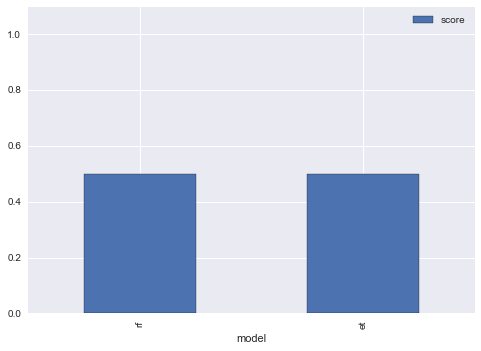

In [12]:
scores = pd.DataFrame([(k, v['score']) for k, v in all_models.iteritems()],
             columns=['model', 'score']).set_index('model').sort_values('score', ascending=False)


scores.plot(kind='bar')
plt.ylim(0.0, 1.1)

scores

In [13]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold

def retest(model):
    scores = cross_val_score(model, X, y,
                             cv=StratifiedKFold(y, shuffle=True),
                             n_jobs=-1)
    m = scores.mean()
    s = scores.std()
    
    return m, s

for k, v in all_models.iteritems():
    cvres = retest(v['model'])
    print k, 
    all_models[k]['cvres'] = cvres

et rf


,score,error
model,,
rf,0.490425,0.001758
et,0.488913,0.001347


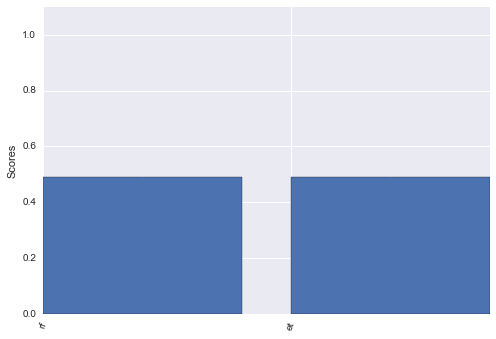

In [14]:
cvscores = pd.DataFrame([(k, v['cvres'][0], v['cvres'][1] ) for k, v in all_models.iteritems()],
                        columns=['model', 'score', 'error']).set_index('model').sort_values('score', ascending=False)



fig, ax = plt.subplots()
rects1 = ax.bar(range(len(cvscores)), cvscores.score,
                yerr=cvscores.error,
                tick_label=cvscores.index)

ax.set_ylabel('Scores')
plt.xticks(rotation=70)
plt.ylim(0.0, 1.1)

# cvscores.to_csv('../../../5.2-lesson/assets/datasets/car_evaluation/model_comparison.csv')
cvscores

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

onehotpipe = make_pipeline(OneHotEncoder(),
                           rf)


all_models['onehotpipe'] = {'model': onehotpipe,
                            'score': evaluate_model(onehotpipe)}

[[ 541    2  799   31]
 [   8    1   37    1]
 [ 429    3 1231   64]
 [ 106    1  295   23]]
             precision    recall  f1-score   support

          0       0.50      0.39      0.44      1373
          1       0.14      0.02      0.04        47
          2       0.52      0.71      0.60      1727
          3       0.19      0.05      0.08       425

avg / total       0.47      0.50      0.47      3572



In [16]:
onehotpipe = make_pipeline(OneHotEncoder(),
                           et)


all_models['onehotpipe'] = {'model': onehotpipe,
                            'score': evaluate_model(onehotpipe)}

[[ 582    3  763   25]
 [   9    1   36    1]
 [ 482    9 1197   39]
 [ 129    2  278   16]]
             precision    recall  f1-score   support

          0       0.48      0.42      0.45      1373
          1       0.07      0.02      0.03        47
          2       0.53      0.69      0.60      1727
          3       0.20      0.04      0.06       425

avg / total       0.46      0.50      0.47      3572



In [19]:
onehotpipe_rf = make_pipeline(OneHotEncoder(),
                           rf)


all_models['onehotpipe_rf'] = {'model': onehotpipe_rf,
                            'score': evaluate_model(onehotpipe_rf)}

[[ 543    1  788   41]
 [   7    1   37    2]
 [ 458    3 1198   68]
 [ 112    1  283   29]]
             precision    recall  f1-score   support

          0       0.48      0.40      0.44      1373
          1       0.17      0.02      0.04        47
          2       0.52      0.69      0.59      1727
          3       0.21      0.07      0.10       425

avg / total       0.46      0.50      0.47      3572



,score
model,
onehotpipe,0.502800
rf,0.499440
et,0.499160
onehotpipe_rf,0.495801


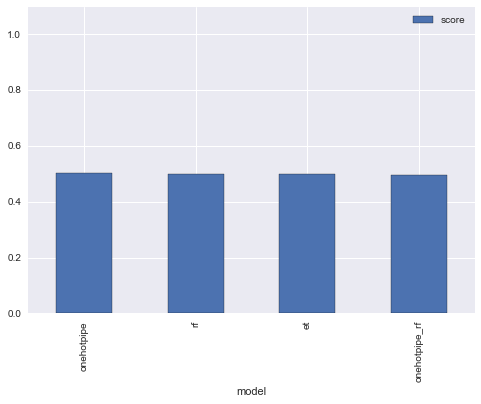

In [20]:
scores = pd.DataFrame([(k, v['score']) for k, v in all_models.iteritems()],
             columns=['model', 'score']).set_index('model').sort_values('score', ascending=False)

scores.plot(kind='bar')
plt.ylim(0.0, 1.1)

scores